# Intermezzo: Collecting data from a Causal Chamber™

```
From ML Theory to Practice
Universität Potsdam, fall semester 2025

Authors: Juan L. Gamella and Simon Bing
License: CC-BY-4.0 https://creativecommons.org/licenses/by/4.0/
```

## Learning Objectives

The goal of this (short) exercise is to familiarize you with the Causal Chamber™ remote lab, so you can collect your own data from the chambers.

Here we will focus on submitting experiments to the queue system. We will explore real-time operation later in the course, when we look at control & RL.

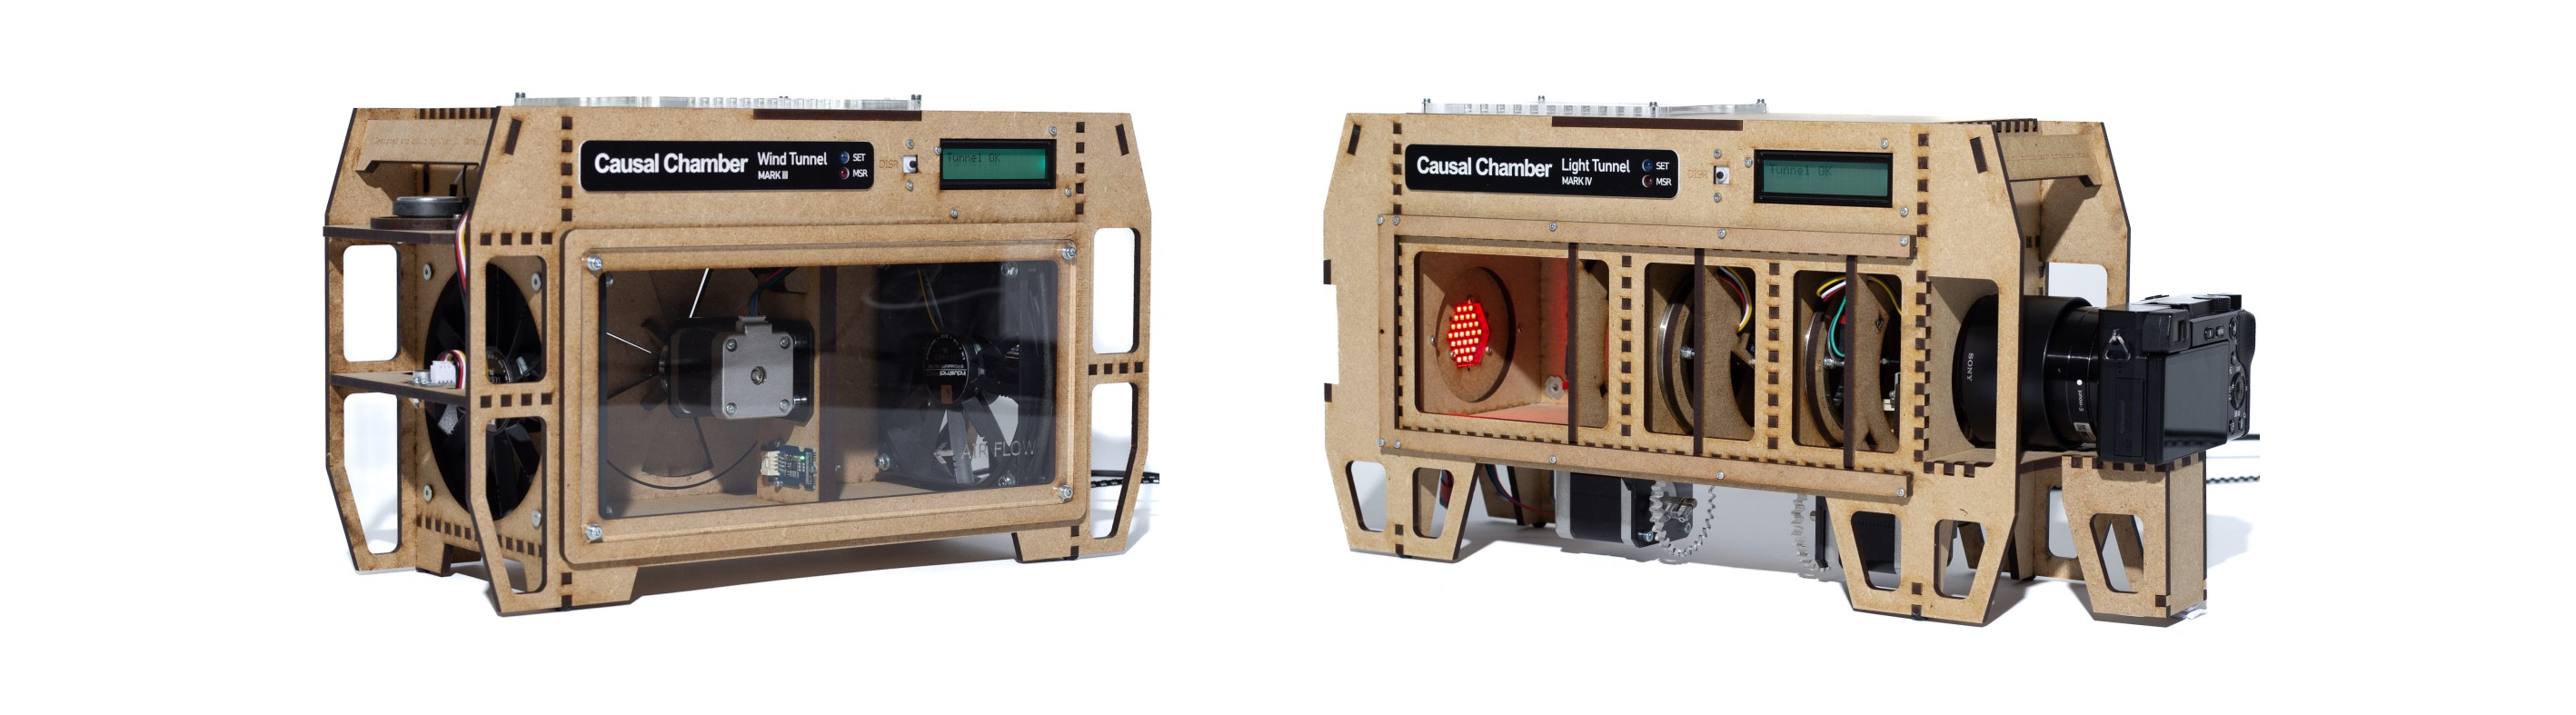

## Setup

### 1. Install the causalchamber package

You can install it via pip, i.e., by calling

```
pip install causalchamber
```

in an appropriate shell.

In [1]:
import causalchamber


Fetching list of available datasets from
  https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.


Citation
--------

If you use our datasets, simulators or Remote Lab for your work, please consider citing:

﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}


Support & feedback
------------------

If you encounter bugs o have feedback, please write us an email at

  support@causalchamber.ai

or leave an issue at

  https://github.com/juangamella/causal-chamber-package/issues

If you are a Remote Lab subscriber, contact us directly through any of
the provided support channels.



### 2. Create yor credentials file

You should have received your API credentials from us through a secure link. If the link has expired, please contact us at support@causalchamber.ai.

To make your credentials accessible to the causalchamber package, you can create a credentials file, e.g., `.credentials` with the following contents.

```
[api_keys]
user = <YOUR USERNAME>
password = <YOUR PASSWORD>
```

The filename does not matter, but you should keep this file in a safe place. In particular, you should **NEVER COMMIT THIS FILE**, as your api keys can be exposed to the public. If you create this file in a directory tracked by git, add it to the [.gitignore](https://git-scm.com/docs/gitignore) file to avoid it being commited by accident.

### 3. You're ready to go!

Open a connection to the remote lab as follows.

In [3]:
import causalchamber.lab as lab
rlab = lab.Lab(credentials_file = '/home/matteo/Desktop/Uni/canton.credentials')



Chambers

  Status   Chamber ID     Model              Mode    Valid Configurations  
───────────────────────────────────────────────────────────────────────────
  READY    lt-ptdm-fu3p   Light Tunnel Mk2   queue   'standard'            
───────────────────────────────────────────────────────────────────────────


Experiments

  Status   Tag   Experiment ID   Chamber ID   Config   Submitted On  
─────────────────────────────────────────────────────────────────────
─────────────────────────────────────────────────────────────────────
 Date/time in your machine's local timezone — current time = Mon, Oct 27, 2025 17:02:20 CET



Above you can see the chambers you have access to, and the list of experiments you have submitted.

## Submitting an experiment to the queue

Now, lets create an experiment and submit it to the queue.

First, specify the chamber that should run your experiment and its configuration:

In [4]:
experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')

You can check the available chambers & configs in the chamber table above, or by calling `rlab.get_available_chambers()`.

Now, you can add instructions to the experiment protocol.

In [5]:
experiment.set('red', 64)

The above is a **SET** instruction: the chamber will set the target variable to the given value and continue once the change is done. In this case, we set the brightness of the red channel of the light source to `64`. You can find the list of variables and their values [here](https://cchamber-box.s3.eu-central-2.amazonaws.com/config_doc_lt_mk2_camera_standard.pdf).

In [6]:
experiment.measure(n=100)

The above is a **MEASURE** instruction: the chamber takes `n` successive measurements of all variables. You can set an additional parameter `delay` to add an additional delay (in milliseconds) between measurements; if unset, `delay` defaults to 0.

If you want to add a delay between two consecutive instructions, you can use the **WAIT** instruction:

In [7]:
experiment.wait(milliseconds=100)

You can see which instructions are currently in the protocol by calling `.instructions`

In [8]:
experiment.instructions

['SET,red,64.0', 'MSR,100,0', 'WAIT,100']

where MSR is equivalent to MEASURE.

If you want to start over, you can clear the instructions by calling `.clear()`

In [9]:
experiment.clear()
experiment.instructions

[]

Now, lets write a simple experiment where we set the light source to random colors and see their effect on the light sensors.

The color of the light source is controlled by the variables `red`, `green` and `blue`, which control the brightness of each color channel.

In [10]:
import numpy as np

experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')

N = 100
for i in range(N):
    experiment.set('red', np.random.randint(255))
    experiment.set('green', np.random.randint(255))
    experiment.set('blue', np.random.randint(255))
    experiment.measure(n=1)

To submit the experiment to the queue, call `experiment.submit()`

In [11]:
experiment_id = experiment.submit(tag='rand_colors')

This will return the experiment_id. You can specify an optinal `tag` parameter to help you keep track of your experiments.

You can monitor the status of your experiment by calling `rlab.get_experiments()`

In [14]:
_ = rlab.get_experiments(print_max=10)


  Status   Tag           Experiment ID                          Chamber ID     Config     Submitted On                    
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  DONE     rand_colors   e1908897-63e1-4213-aae7-21d635a49bee   lt-ptdm-fu3p   standard   Mon, Oct 27, 2025 17:04:20 CET  
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Date/time in your machine's local timezone — current time = Mon, Oct 27, 2025 17:04:47 CET



or directly by calling

In [13]:
rlab.get_experiment(experiment_id)['status']

'DONE'

Once the experiment is done, you can take the experiment id from the table and download its data. `root=` sets the download folder in your computer.

In [15]:
data = rlab.download_data(experiment_id = experiment_id, root='/tmp')
df = data.dataframe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19.5k/19.5k [00:00<00:00, 477kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.


Let's plot the results!

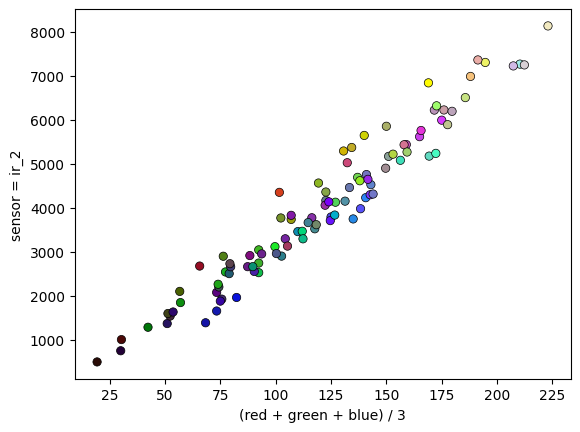

In [16]:
import matplotlib.pyplot as plt

def plot_sensor(sensor):
    color = df[['red', 'green', 'blue']].values
    plt.scatter(color.sum(axis=1) / 3, df[sensor], c=color/255, edgecolor='black', linewidth=0.5)
    plt.ylabel(f"sensor = {sensor}")
    plt.xlabel("(red + green + blue) / 3")

plot_sensor('ir_2')

The above plots the readings of the second IR (infrared) sensor (`ir_2`). The color of each observation representing the red/green/blue levels of the light source.

You can see how the IR sensor is most sensitive to red light, and less sensitive to green and blue. If you plot the readings of the visible light sensor on the same chip (`vis_2`), you can see this pattern reverse.

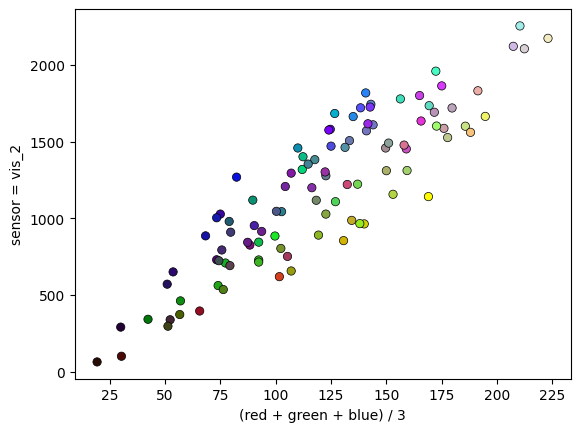

In [17]:
plot_sensor('vis_2')

## Your turn!

Now, you will write code to run an experiment and visualize the effect that the polarizers have on the light passing through them.

This effect is described by [Malus' law](https://en.wikipedia.org/wiki/Polarizer#Malus's_law_and_other_properties), which says that two polarizers placed one after another (like in the tunnel), dim the light passing through them by a factor of

$$\cos^2(\theta_1 - \theta_2)$$

where $\theta_1$ and $\theta_2$ are the angles of the polarizer axes. In the chamber, the polarizer angles are controlled with the variables `pol_1` and `pol_2`,

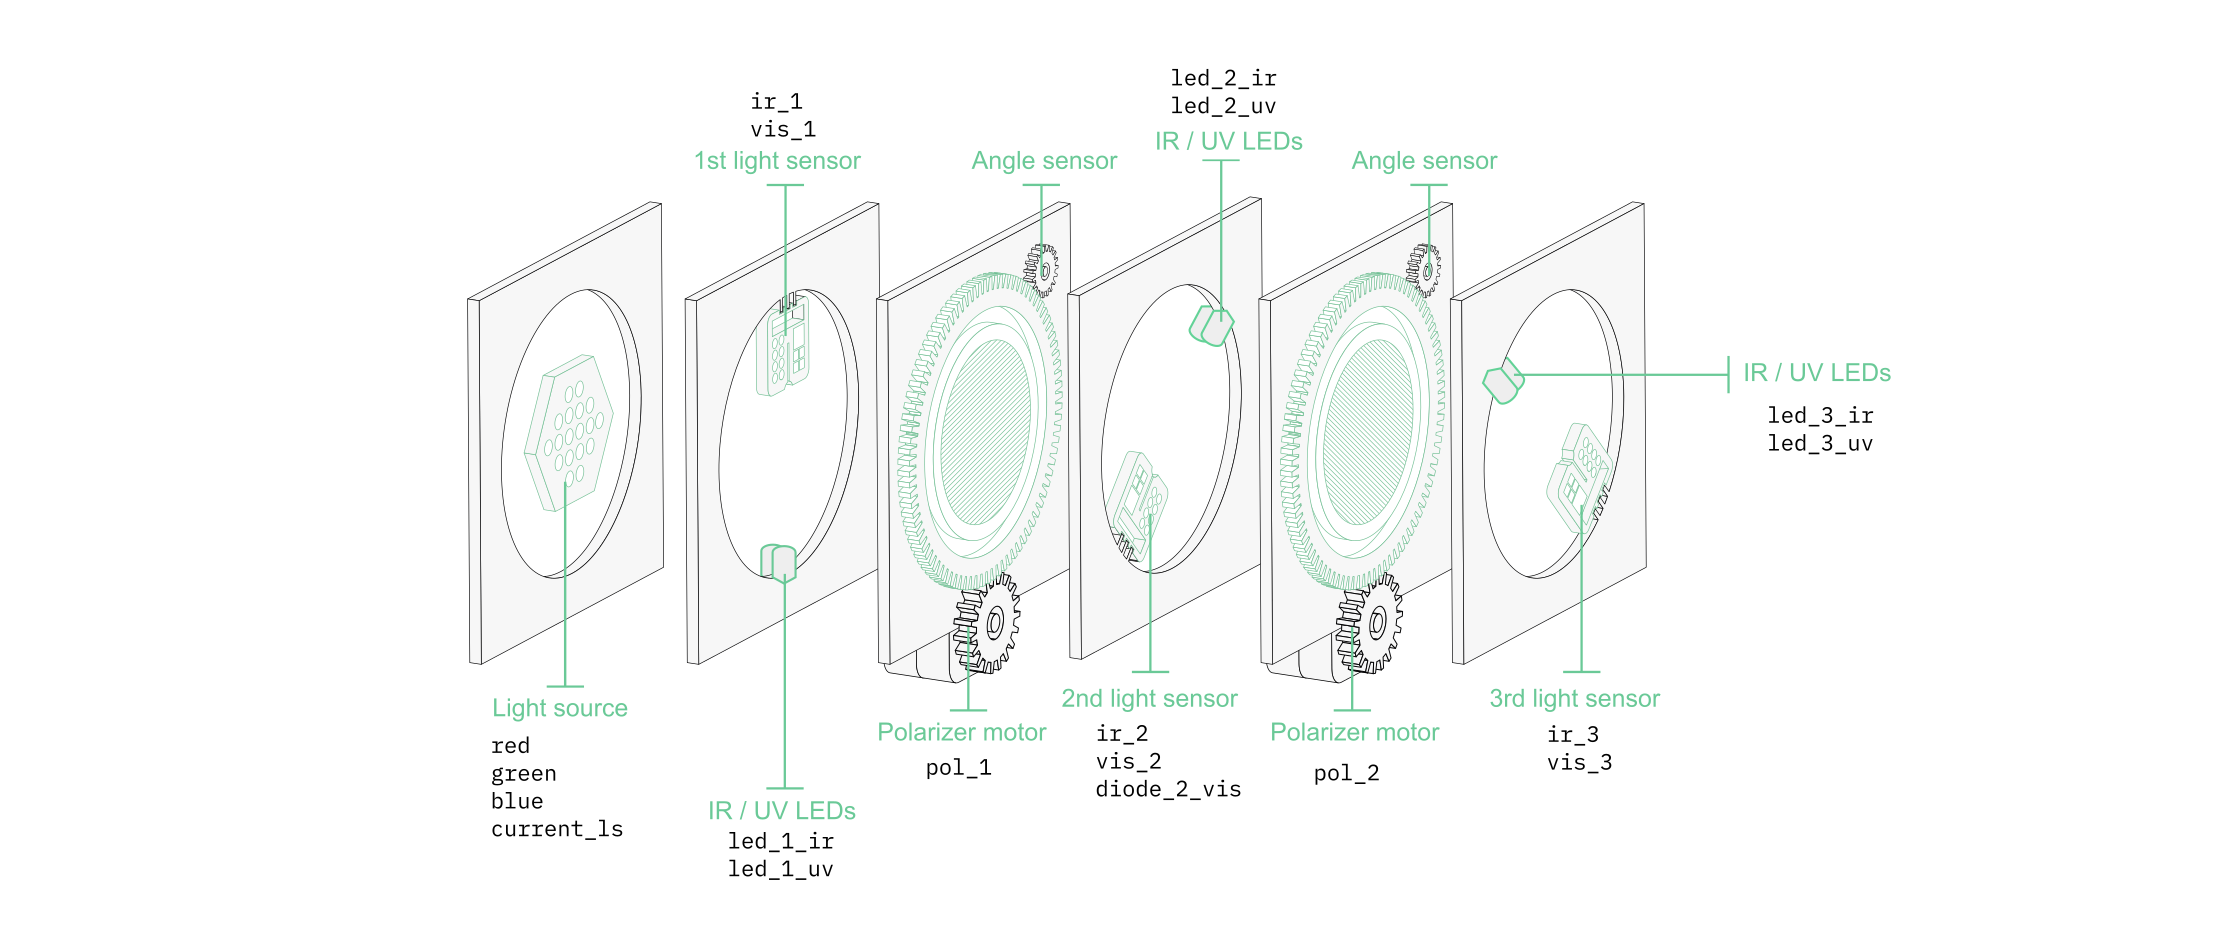

<mark style="background-color: #40E0D0;"> Task </mark> 

Write an experiment where

1. You set the light source to white, e.g., `red` = `green` = `blue` = 128.
2. You set the polarizers (`pol_1` and `pol_2`) to random positions sampled from `[-90, 90]`
4. You take one measurement
5. Repeat 2 and 3 `N=50` times

In [27]:
experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config='standard')
# TODO: your code here



experiment.set('red', 128)
experiment.set('green',128)
experiment.set('blue', 128)

N = 50
for i in range(N):
    experiment.set('pol_1',np.random.randint(-90,91))
    experiment.set('pol_2',np.random.randint(-90,91))
    experiment.measure(n=1)

np.int64(0)

Once you're done, submit your experiment

In [36]:
experiment_id = experiment.submit(tag='TODO')

and monitor its status

In [47]:
_ = rlab.get_experiments(print_max=10)


  Status   Tag           Experiment ID                          Chamber ID     Config     Submitted On                    
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  DONE     TODO          ec3fa5c5-ea24-4f56-8eda-17456e4121e4   lt-ptdm-fu3p   standard   Mon, Oct 27, 2025 17:18:58 CET  
  DONE     TODO          02249115-0e80-494c-840a-61a18de47c05   lt-ptdm-fu3p   standard   Mon, Oct 27, 2025 17:18:00 CET  
  DONE     rand_colors   e1908897-63e1-4213-aae7-21d635a49bee   lt-ptdm-fu3p   standard   Mon, Oct 27, 2025 17:04:20 CET  
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Date/time in your machine's local timezone — current time = Mon, Oct 27, 2025 17:20:47 CET



Once finished, download the data

In [103]:
data = rlab.download_data(experiment_id = 'ec3fa5c5-ea24-4f56-8eda-17456e4121e4', root = '/tmp')
df = data.dataframe

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.0k/13.0k [00:00<00:00, 11.9MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.


<mark style="background-color: #40E0D0;"> Task </mark> 

Now, plot the results. Make a scatter plot with
- x-axis: the relative polarizer angle `pol_1 - pol_2`
- y-axis: the reading of the third IR and visible sensors (`ir_3, vis_3`), which are placed after the two polarizers, wrt. to the light source.

In [104]:
# TODO: Your code goes here

def plot_sensor_2(sensor):
    delta_pol = df[['pol_1']].values-df[['pol_2']].values
    plt.scatter(delta_pol, df[sensor],  edgecolor='black', linewidth=0.5)
    plt.ylabel(f"sensor = {sensor}")
    plt.xlabel("(pol_1 - pol_2)")

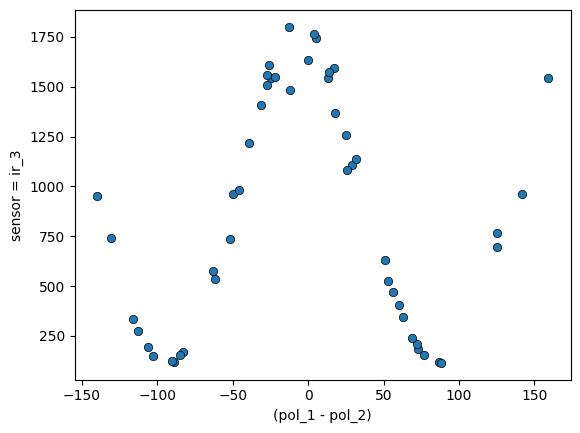

In [105]:
plot_sensor_2("ir_3")

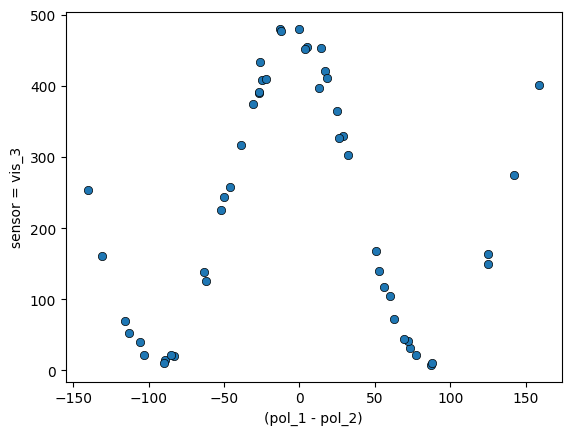

In [106]:
plot_sensor_2("vis_3")